# Visualizing your outputs using dimensionality reduction
---

## How does Hume build its visualizations?

The embedding plot you see on beta.hume.ai is a form of high-dimensional data visualization utilizing [UMAP](https://umap-learn.readthedocs.io/en/latest/) (uniform manifold approximation and projection for dimension reduction). This is a form of dimensionality reduction, which is a family of methods for taking high-dimensional data (like the 48+ outputs of our expression measurement models) and reducing them for descriptive and visualization purposes into a lower-dimensional space. Some other forms of dimensionality reduction you might be familiar with are PCA (principal components analysis), and t-SNE (t-distributed stochastic neighbor embedding), which are complementary ways to understand the structure and distribution of your data.

The basic goal of a dimensionality reduction is to preserve as much information as possible about the relationship between points in high-dimensional space, while simplifying the presentation to a smaller number of dimensions (usually two, for visualization purposes).

Hume’s measurement API returns up to 53 categories of emotions that people can perceive in complex patterns of expression. It would be impossible to create a standard scatterplot of this data, since we can’t visualize 48+ dimensions. Methods like UMAP use dimensionality reduction to simplify high-dimensional spaces into spaces that are easier for humans to understand (like 2D and 3D). 

These methods can be used to explore and identify structure in your data. You might find that your data organizes into distinct clusters, or that it is evenly distributed throughout the space. Using labels, you can also tell which classes are “closer” to one another in high-dimensional space.

This tutorial notebook will show you how to use PCA, t-SNE, and UMAP to build visualizations of your data.

The example output ```predictions.json``` are the outputs from Hume's facial expression model for [this video clip](https://www.youtube.com/watch?v=BGMoDORKN8Y) from our podcast [The Feelings Lab](https://open.spotify.com/show/19ieQiPrcfbNHiquiPK74w?si=abbfbf8e1eb44c2a).


---
## PCA
---

To start, we'll import libraries, load in the ```predictions.json```, and get it into a format that will be easy to work with.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
data = pd.read_json('predictions.json')
face_data = pd.DataFrame(data['results'][0]['predictions'][0]['models']['face']['grouped_predictions'][0]['predictions'])
emotions = [d['name'] for d in face_data['emotions'][0]]
emotions_data = pd.DataFrame(face_data['emotions'].to_list(),columns=emotions)
for emotion in emotions:
    emotions_data[emotion] = pd.json_normalize(emotions_data[emotion])['score']
face_data = face_data.join(emotions_data)
face_data.head()

# create a column to keep track of the top emotion per frame
face_data['Emotion'] = face_data[emotions].idxmax(axis=1)

We'll use this ```face_data``` dataframe for the rest of the tutorial.

Now we can run PCA to reduce the dimensionality of our data to two dimensions:

In [3]:
X = face_data[emotions]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

<Axes: >

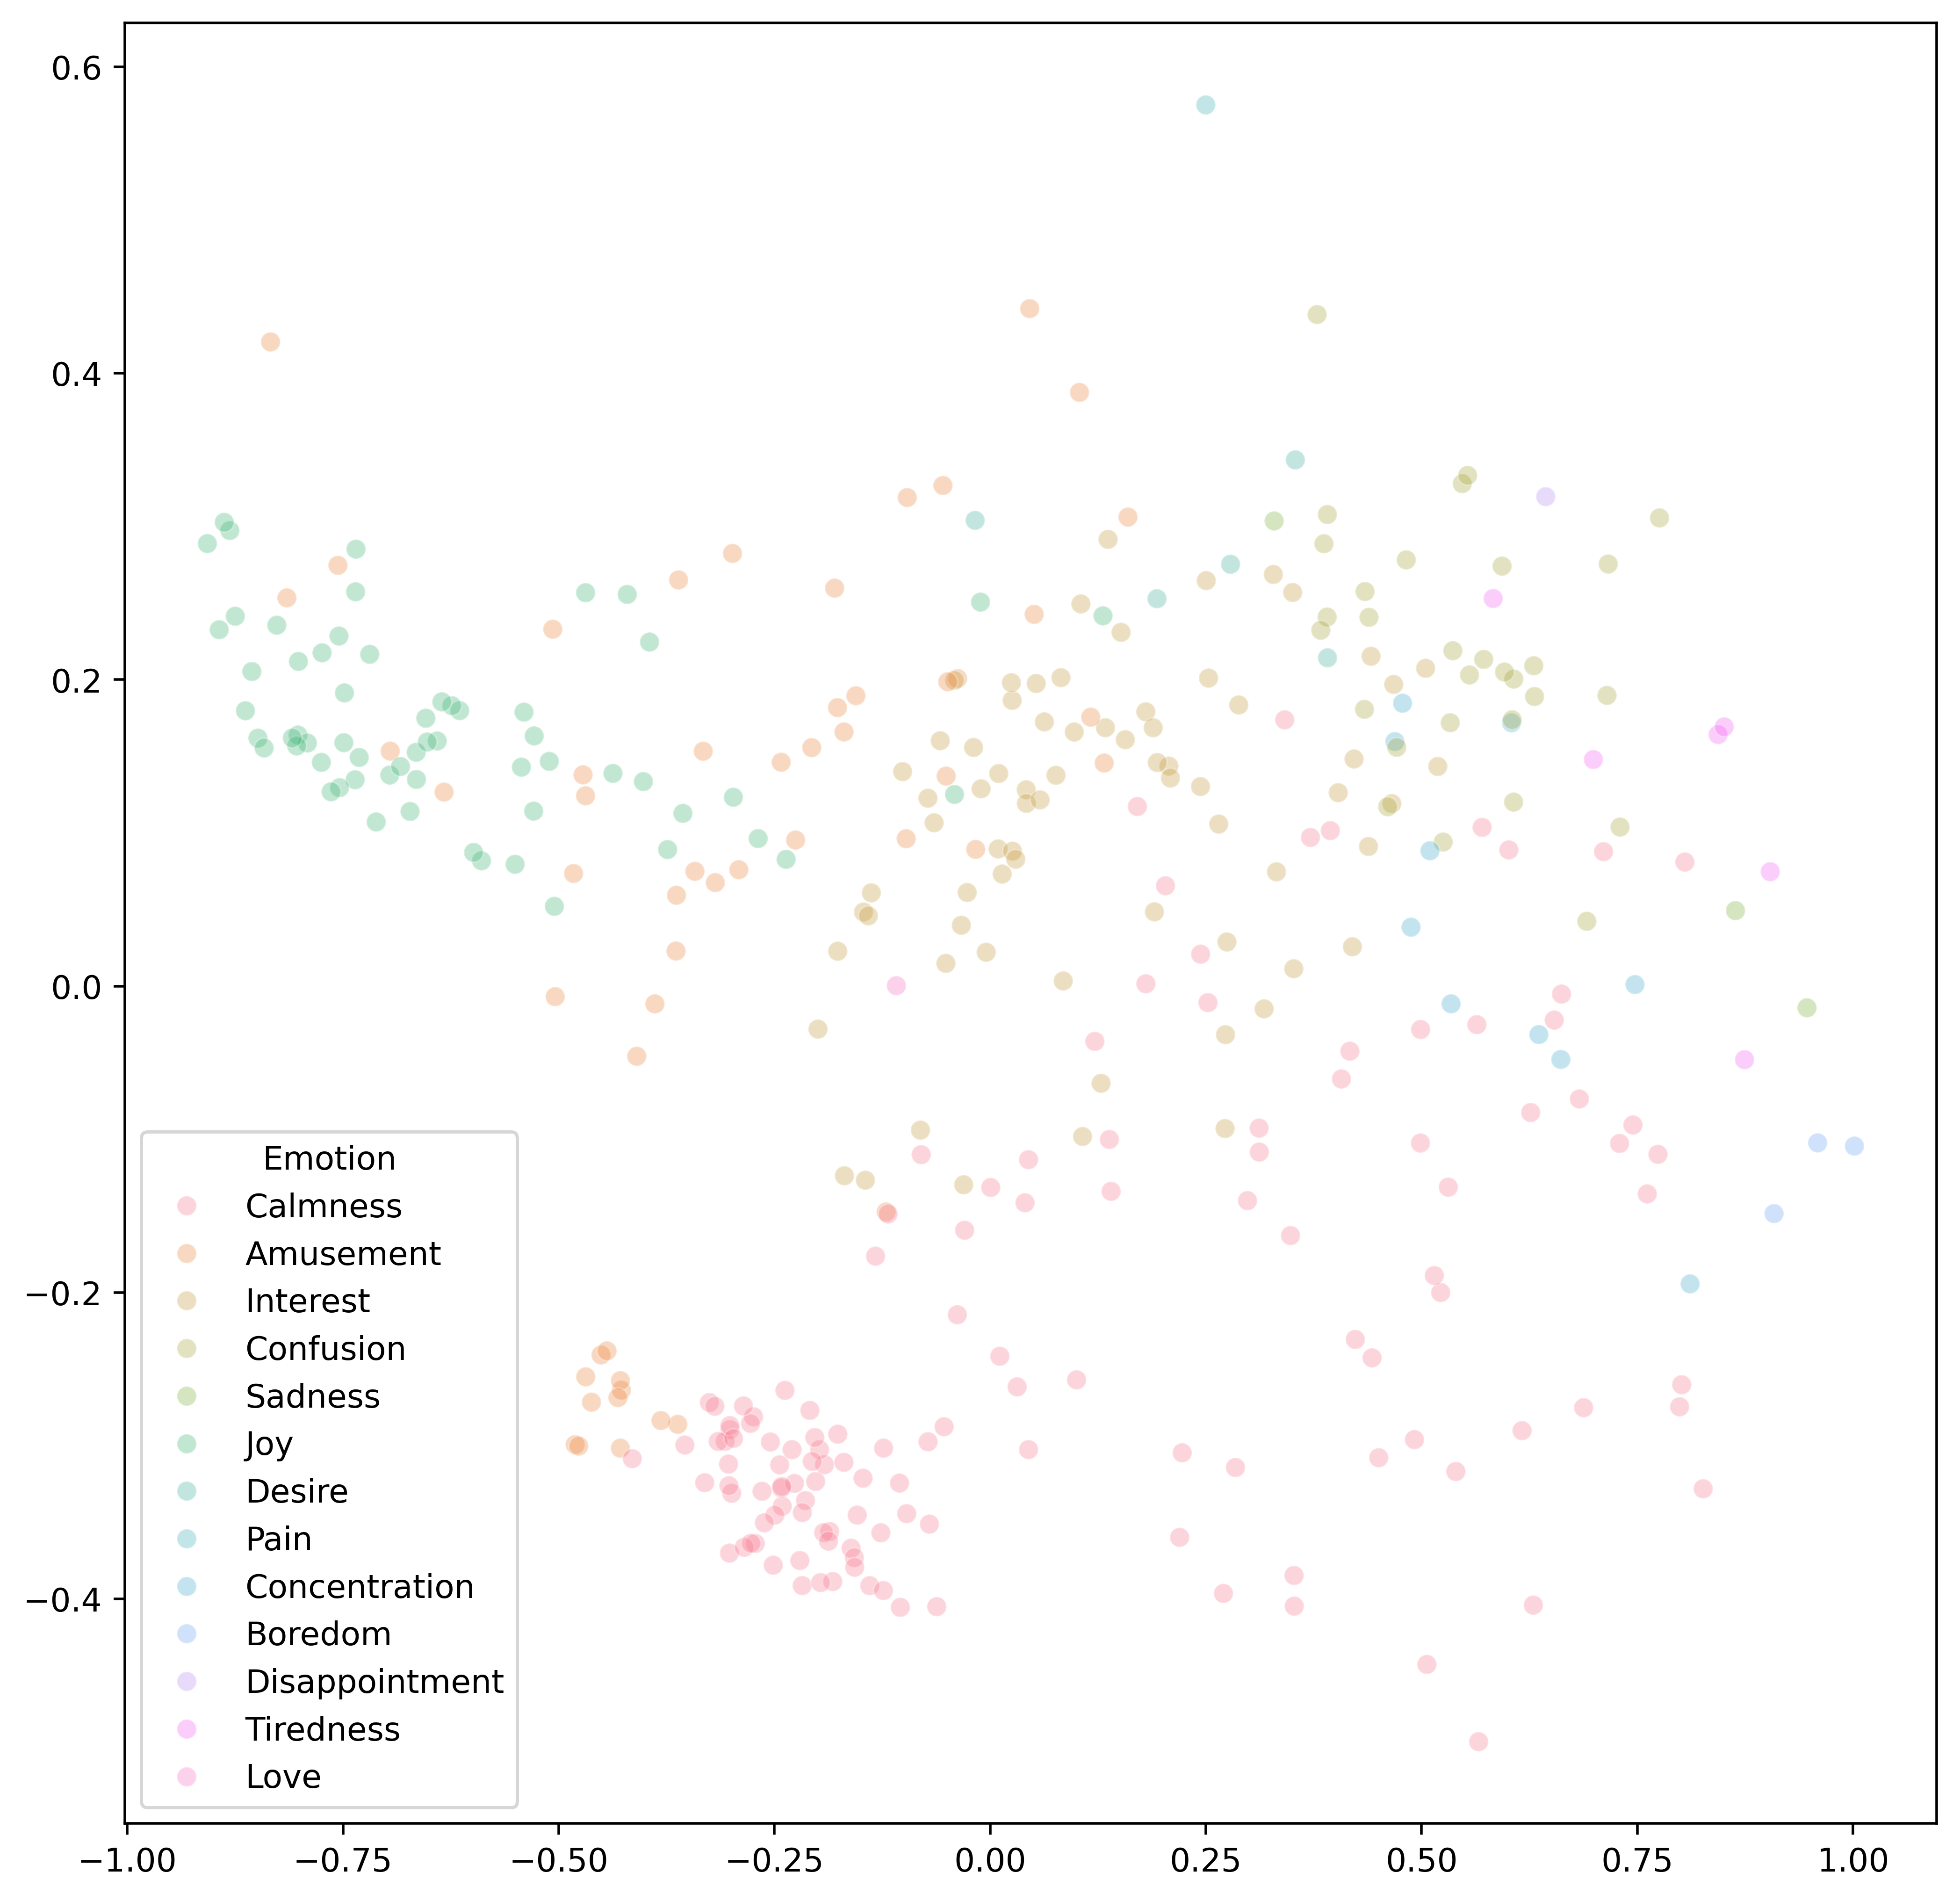

In [21]:
plt.figure(figsize=(10,10),dpi=500)
sns.scatterplot(
        x=components[:, 0], y=components[:, 1],
        hue="Emotion",
        data=face_data[emotions].join(face_data["Emotion"]),
        legend="full",
        alpha=0.3
    )

In [4]:
fig = px.scatter(components, x=0, y=1, color=face_data['Emotion'])
fig.show()

---
## t-SNE
---

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(face_data[emotions])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 376 samples in 0.000s...
[t-SNE] Computed neighbors for 376 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 376 / 376
[t-SNE] Mean sigma: 0.139936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.354206
[t-SNE] KL divergence after 300 iterations: 0.339526


In [14]:
plt.figure(figsize=(8,8),dpi=500)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=face_data['Emotion'],
    palette=sns.color_palette("hls", 10),
    data=face_data[emotions],
    legend="full",
    alpha=0.3
)

/var/folders/l4/wzjsg2b94bx5xrgh6dcy36xc0000gn/T/ipykernel_25531/2047812857.py:2: UserWarning:


The palette list has fewer values (10) than needed (13) and will cycle, which may produce an uninterpretable plot.



<Axes: >

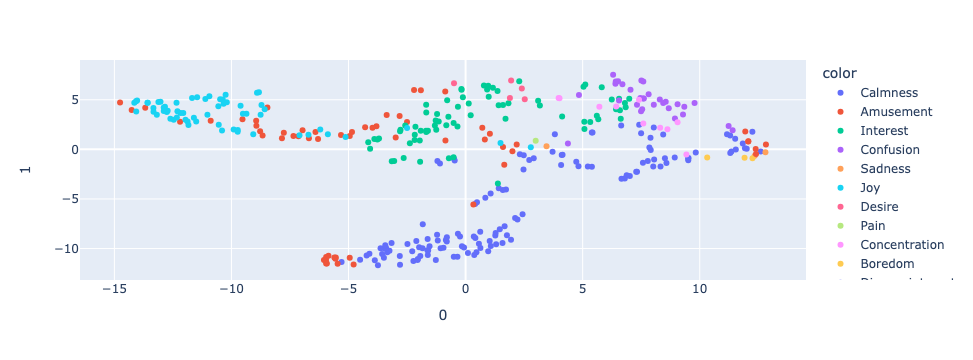

In [22]:
fig = px.scatter(tsne_results, x=0, y=1, color=face_data['Emotion'])
fig.show()

---
## UMAP
---

<Axes: >

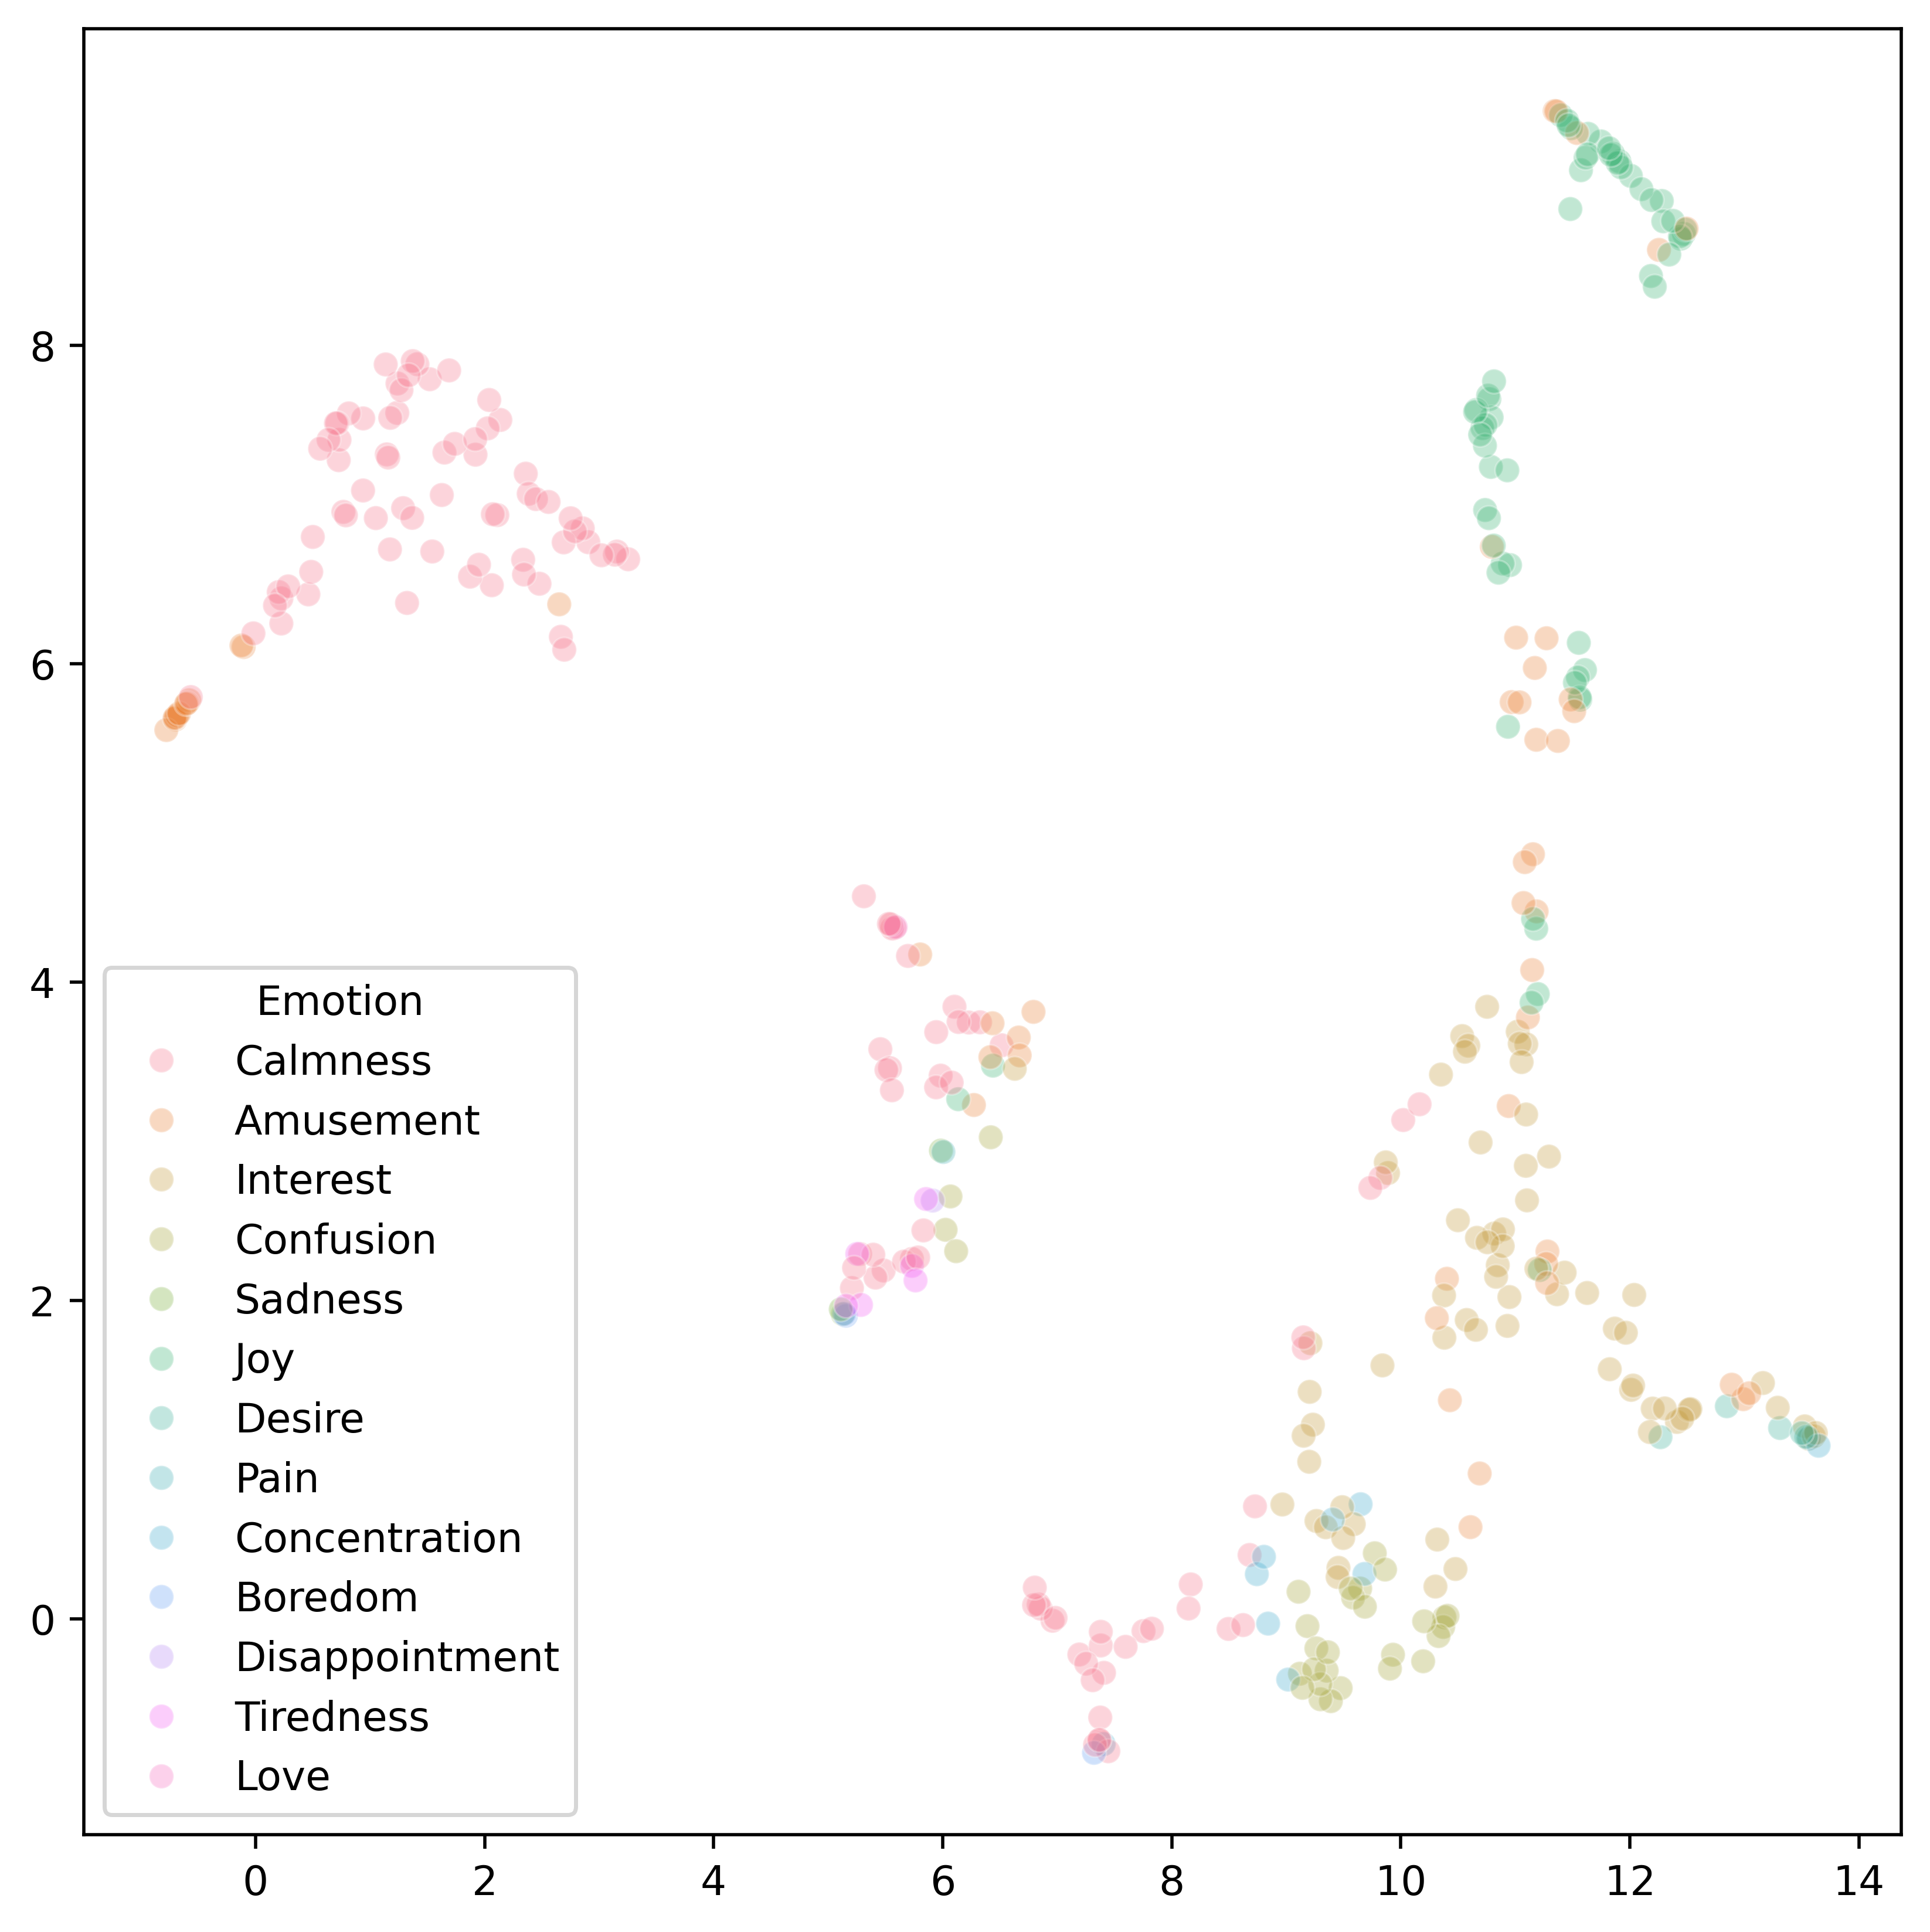

In [15]:
import umap

reducer = umap.UMAP()

data_for_umap = face_data[emotions]
scaled_data = StandardScaler().fit_transform(data_for_umap)
embedding = reducer.fit_transform(scaled_data)

# plot it
plt.figure(figsize=(8,8),dpi=500)
sns.scatterplot(
        x=embedding[:, 0], y=embedding[:, 1],
        hue="Emotion",
        data=face_data[emotions].join(pd.DataFrame(face_data['Emotion'])),
        legend="full",
        alpha=0.3
    )

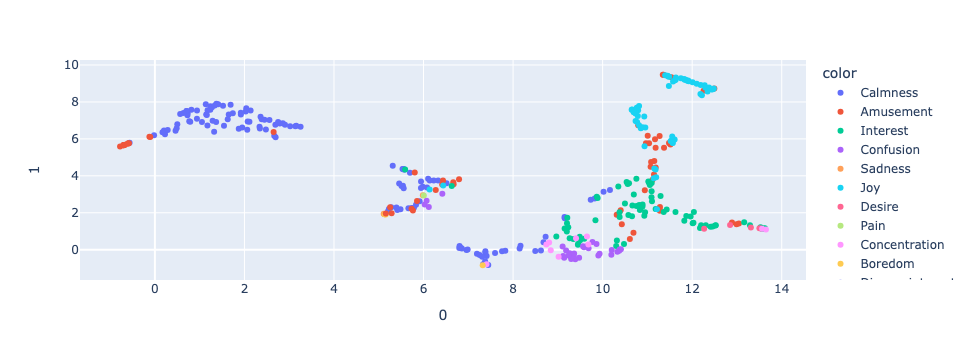

In [23]:
fig = px.scatter(embedding, x=0, y=1, color=face_data['Emotion'])
fig.show()

---
## Interpreting your visualization
---

The most informative aspect of a visualization like this is the clusters found in the data. Was the algorithm able to cleanly separate different classes into visual clusters, or is there an even distribution of points? 

But remember to exercise caution when interpreting characteristics of the distribution like the size of the clusters or the distances between clusters.

The algorithm is stochastic, meaning that you can re-run the algorithm multiple times with the same hyperparameters and get slightly different results. Moreover, running multiple projections with different hyperparameters can be useful to understand what is going on with your data.
